In [1]:
import pandas as pd

In [2]:
hfile = 'data/heroes.csv'

In [3]:
H = pd.read_csv(hfile, sep=';')

In [4]:
H.head(2)

,Name,Identity,Birth place,Publisher,Height,Weight,Gender,First appearance,Eye color,Hair color,Strength,Intelligence
0,A-Bomb,Richard Milhouse Jones,"Scarsdale, Arizona",Marvel Comics,203.21,441.95,M,2008.0,Yellow,No Hair,100.0,moderate
1,Abraxas,Abraxas,Within Eternity,Marvel Comics,NaN,NaN,M,NaN,Blue,Black,100.0,high


In [6]:
H.dtypes

Name                 object
Identity             object
Birth place          object
Publisher            object
Height              float64
Weight              float64
Gender               object
First appearance    float64
Eye color            object
Hair color           object
Strength            float64
Intelligence         object
dtype: object

## Data Enrichment using wikidata
Find occupation of SuperHeroes
- lookup hero on wikidata
- disambiguate findings
- look for occupation

In [17]:
import requests
from SPARQLWrapper import SPARQLWrapper, JSON

In [41]:
def search(query, lang='en'):
    url = 'https://www.wikidata.org/w/api.php'
    par = {
        'action': 'wbsearchentities',
        'format': 'json',
        'search': query,
        'language': lang
    }
    response = requests.get(url=url, params=par)
    return response.json()

def sparql(entity_id, lang='en'):
    endpoint_url = "https://query.wikidata.org/sparql"
    sparql = SPARQLWrapper(endpoint_url)
    query = """
    SELECT * WHERE {{
      wd:{sh1} wdt:P31 ?type.
      wd:{sh2} rdfs:label ?entityLabel.
      ?type rdfs:label ?typeLabel.
      OPTIONAL {{
        wd:Q4646886 wdt:P21 ?gender.
      }}
      FILTER (langMatches( lang(?entityLabel), "{lang1}" ) ).
      FILTER (langMatches( lang(?typeLabel), "{lang2}" ) ).
    }}
    """.format(sh1=entity_id, sh2=entity_id, lang1=lang, lang2=lang)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

In [55]:
hero = 'Animal Man'
sh_wikiclass = 'http://www.wikidata.org/entity/Q188784'

Check for type matching

In [57]:
for option in search(hero)['search']:
    data = sparql(option['id'])
    for binding in data['results']['bindings']:
        if binding['type']['value'] == sh_wikiclass:
            print("The best matching entity for {} is {}".format(hero, option['id']))
            break

The best matching entity for Animal Man is Q547391


## Location of birth cities

In [59]:
from geopy.geocoders import Nominatim

In [60]:
geolocator = Nominatim(user_agent="HEROLOC")

In [65]:
location = geolocator.geocode("Chicago Illinois")

In [66]:
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

Chicago, Cook County, Illinois, USA
(41.8755616, -87.6244212)
{'place_id': 197578857, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 122604, 'boundingbox': ['41.644531', '42.0230396', '-87.940101', '-87.5239841'], 'lat': '41.8755616', 'lon': '-87.6244212', 'display_name': 'Chicago, Cook County, Illinois, USA', 'class': 'place', 'type': 'city', 'importance': 1.002647610488886, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_place_city.p.20.png'}


In [67]:
H = H.dropna()

In [71]:
valid_rows = []
for i, hero in H.iterrows():
    bp = hero['Birth place']
    location = geolocator.geocode(bp)
    if location is not None and hero['Publisher'] in ['Marvel Comics', 'DC Comics']:
        hero['Latitude'], hero['Longitude'] = location.latitude, location.longitude
        valid_rows.append(hero)

In [72]:
len(valid_rows)

94

In [73]:
S = pd.DataFrame(valid_rows)

In [74]:
S.head()

,Name,Identity,Birth place,Publisher,Height,Weight,Gender,First appearance,Eye color,Hair color,Strength,Intelligence,Latitude,Longitude
16,Lady Deathstrike,Yuriko Oyama,"Osaka, Japan",Marvel Comics,175.85,58.89,F,1985.0,Brown,Black,30.0,good,34.693757,135.501454
22,Absorbing Man,Carl Creel,"New York City, New York",Marvel Comics,193.36,122.28,M,1964.0,Blue,No Hair,80.0,moderate,40.712728,-74.006015
26,Adam Strange,Adam Strange,"Chicago, Illinois",DC Comics,185.10,88.92,M,1986.0,Blue,Blond,10.0,good,41.875562,-87.624421
46,Warpath,James Proudstar,"Camp Verde, Arizona",Marvel Comics,218.05,158.22,M,1984.0,Brown,Black,75.0,moderate,34.563636,-111.854318
47,War Machine,James Rupert Rhodes,"Philadelphia, Pennsylvania",Marvel Comics,185.01,95.93,M,1979.0,Brown,Brown,80.0,good,39.952724,-75.163526


In [75]:
import matplotlib.pyplot as plt

In [76]:
marvel = S[S['Publisher'] == 'Marvel Comics']
dc = S[S['Publisher'] == 'DC Comics']

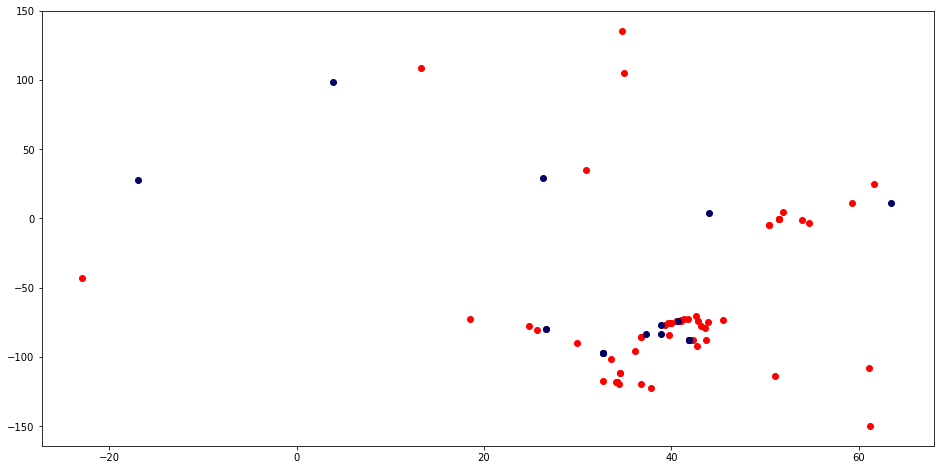

In [87]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(marvel.Latitude, marvel.Longitude, c='#FF0000')
ax.scatter(dc.Latitude, dc.Longitude, c='#000066')
plt.show()

In [79]:
import geopandas as gpd

In [80]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

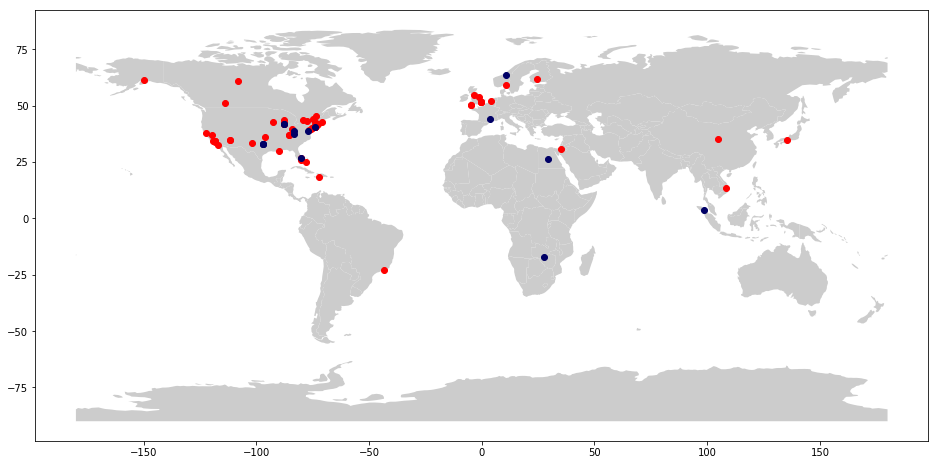

In [88]:
fig, ax = plt.subplots(figsize=(16,8))
world.plot(ax=ax, color='#CCCCCC')
ax.scatter(marvel.Longitude, marvel.Latitude, c='#FF0000')
ax.scatter(dc.Longitude, dc.Latitude, c='#000066')
plt.show()

In [89]:
marvel.to_csv('data/marvel.csv')
dc.to_csv('data/dc.csv')